<b>Problem 1: The aatemp data come from the U.S. Historical Climatological Network. They
are the annual mean temperatures (in degrees F) in Ann Arbor Michigan, going back about
150 years.
    
(a) Fit a linear trend model. Is there a significant linear trend? Interpret your results.

    
(b) Observations in successive years may be correlated. Fit the model that estimates this correlation. Does this change your opinion about the significance of the trend?
    
    
(c) Fit a polynomial model with degree 10 and use backward elimination to reduce the degree of the model. Plot the fitted model on the top of the data. Use this model to predict the temperature in 2001.

    
(d) Make a cubic spline fit with six basis functions evenly spaced on the data range. Plot the fit in comparison with the previous fit. Does this model fit better than the selected polynomial model?

In [382]:
# install.packages('gridExtra')
library('faraway')
data(aatemp)
library(ggplot2)
options(repr.plot.width=12, repr.plot.height=4)
head(aatemp, 3)

year,temp
1854,49.15
1855,46.52
1871,48.80


<b>(a) Fit a linear trend model. Is there a significant linear trend? Interpret your results.

In [383]:
mod = lm(temp ~ year, data = aatemp)
pred = predict(mod, aatemp)

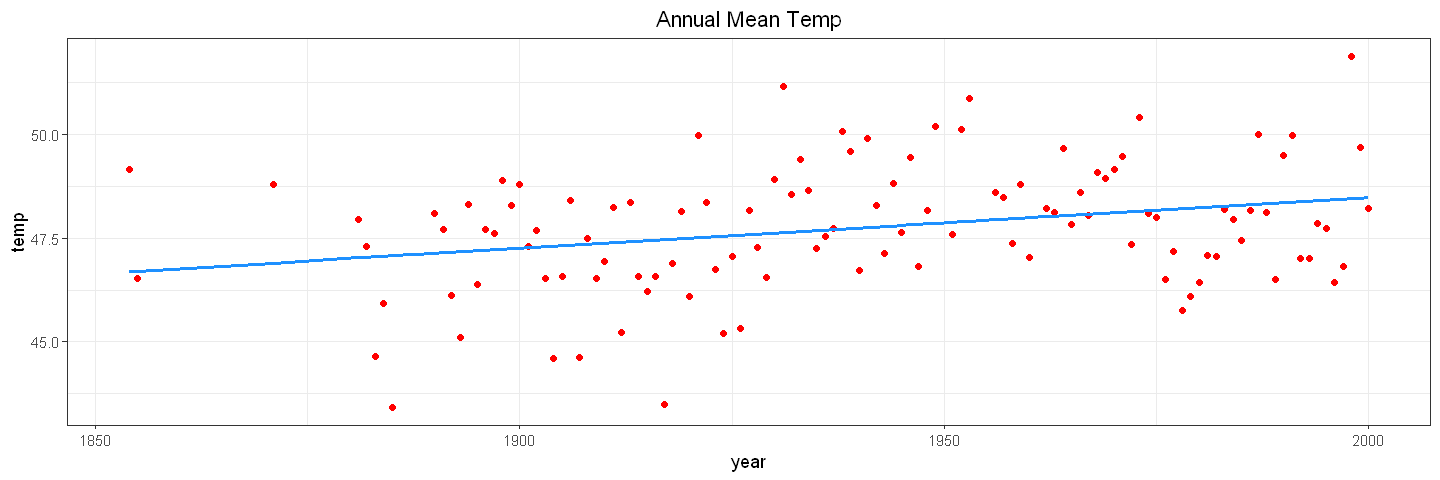

In [384]:
ggplot(data = aatemp, aes(x = year, y = temp))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point(color='red')+
    labs(title='Annual Mean Temp', x='year', y = 'temp')+
    geom_line(aes(x = year, y = pred), color = 'dodgerblue', size = 1)

In [385]:
summary(mod)


Call:
lm(formula = temp ~ year, data = aatemp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9843 -0.9113 -0.0820  0.9946  3.5343 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) 24.005510   7.310781   3.284  0.00136 **
year         0.012237   0.003768   3.247  0.00153 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.466 on 113 degrees of freedom
Multiple R-squared:  0.08536,	Adjusted R-squared:  0.07727 
F-statistic: 10.55 on 1 and 113 DF,  p-value: 0.001533


In [386]:
confint(mod)

,2.5 %,97.5 %
(Intercept),9.521535277,38.48948531
year,0.004771599,0.01970293


* Since $\beta$ coefficient for year is very low, there seems to be a very small linear trend between year and temp.

<b>(b) Observations in successive years may be correlated. Fit the model that estimates this correlation. Does this change your opinion about the significance of the trend?

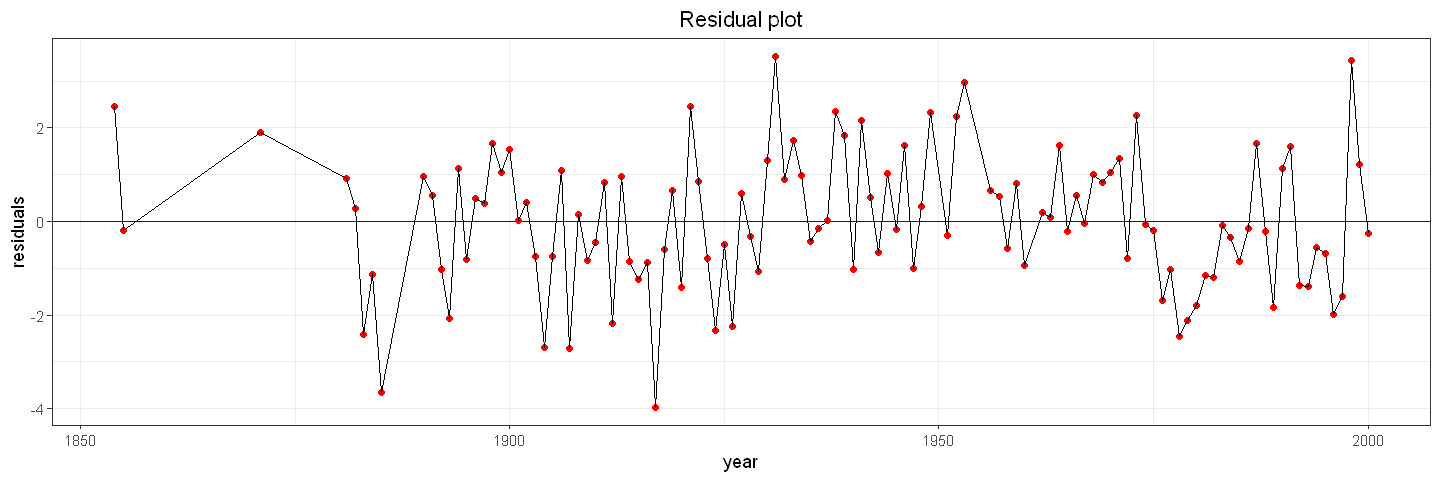

In [387]:
ggplot(data = aatemp, aes(x = year, y = mod$res))+
    geom_point()+
    geom_hline(yintercept = 0, color = 'blue') +
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    labs(title='Residual plot', x='year', y = 'residuals')+
    geom_point(color='red')+
    geom_line()

* The residuals look like auto correlated with time. The value of a residual at a particular point depend upon value of preceding residual.
* Lets confirm it by Derbin-Watson test

In [388]:
dwtest(mod)


	Durbin-Watson test

data:  mod
DW = 1.6177, p-value = 0.01524
alternative hypothesis: true autocorrelation is greater than 0


* The low p value of Durbin-Watson test indicates that residuals are correlated. The value of a residual depend upon value of preceding residual.
* Here, we can interpret that, if annual mean temperature of a given year is low, the mean temperature for succeding year changes with respect to the year given. Basically, shift in mean temperature happens gradually rather than sudden spikes.
* Since the null hypothesis of no autocorrelation is failed from Durbin-Watson test, we can fit generalized linear model.

In [389]:
library(nlme)
mod_b = gls(temp ~ year, correlation = corARMA(p=1), data = aatemp)
summary(mod_b)

Generalized least squares fit by REML
  Model: temp ~ year 
  Data: aatemp 
       AIC     BIC    logLik
  427.2854 438.195 -209.6427

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.2029313 

Coefficients:
                Value Std.Error  t-value p-value
(Intercept) 24.604907  8.935293 2.753677  0.0069
year         0.011931  0.004606 2.590398  0.0108

 Correlation: 
     (Intr)
year -1    

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.71297226 -0.62233530 -0.04994469  0.67429317  2.39436044 

Residual standard error: 1.472974 
Degrees of freedom: 115 total; 113 residual

In [390]:
intervals(mod_b)

Approximate 95% confidence intervals

 Coefficients:
                  lower        est.       upper
(Intercept) 6.902479671 24.60490705 42.30733442
year        0.002805908  0.01193074  0.02105558
attr(,"label")
[1] "Coefficients:"

 Correlation structure:
         lower      est.     upper
Phi 0.01264178 0.2029313 0.3790359
attr(,"label")
[1] "Correlation structure:"

 Residual standard error:
   lower     est.    upper 
1.284087 1.472974 1.689647 

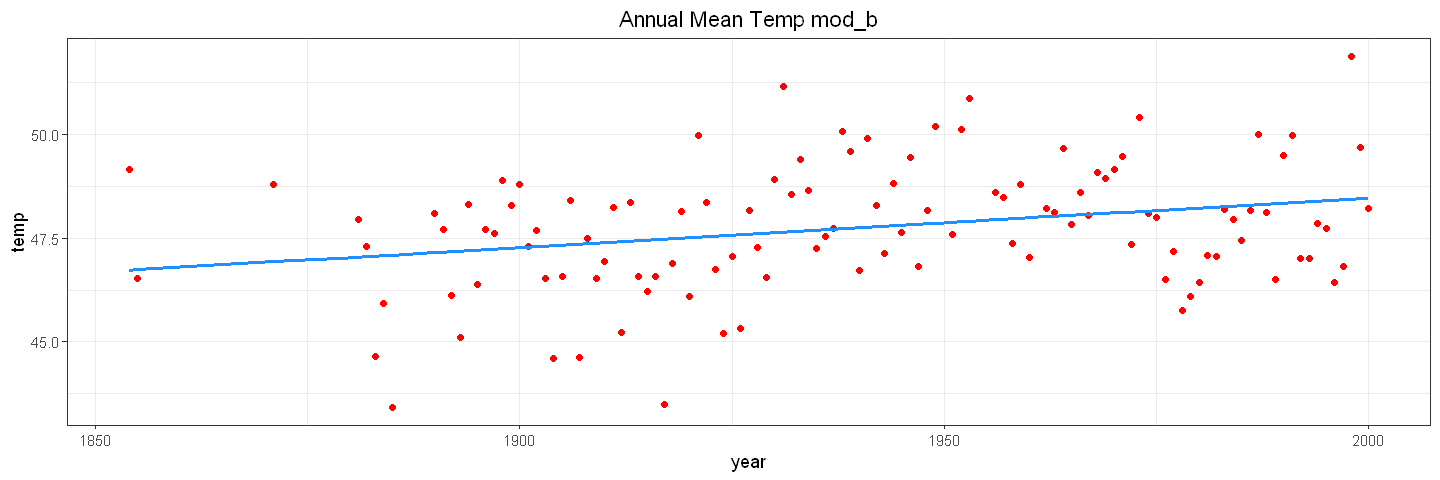

In [391]:
pred = predict(mod_b, aatemp)
ggplot(data = aatemp, aes(x = year, y = temp))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point(color='red')+
    labs(title='Annual Mean Temp mod_b', x='year', y = 'temp')+
    geom_line(aes(x = year, y = pred), color = 'dodgerblue', size = 1)

* 95% confidence interval for $\beta$ coefficient of year does not include zero. Hence, there is a very small linear relationship with year and temp.

<b>(c) Fit a polynomial model with degree 10 and use backward elimination to reduce the degree of the model. Plot the fitted model on the top of the data. Use this model to predict the temperature in 2001.

In [392]:
mod_c = lm(temp ~ year + I(year^2) + I(year^3) + I(year^4)+ I(year^5)+ I(year^6) +I(year^7)+
           I(year^8)+I(year^9) + I(year^10), data = aatemp)
# mod_c = lm(temp ~ year + I(year)^2)
# round(summary(mod_c)$coef,3)
summary(mod_c)


Call:
lm(formula = temp ~ year + I(year^2) + I(year^3) + I(year^4) + 
    I(year^5) + I(year^6) + I(year^7) + I(year^8) + I(year^9) + 
    I(year^10), data = aatemp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7126 -0.9175 -0.1441  0.9905  3.2313 

Coefficients: (5 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -7.049e+07  2.972e+07  -2.372   0.0194 *
year         1.676e+05  7.047e+04   2.379   0.0191 *
I(year^2)   -1.526e+02  6.396e+01  -2.385   0.0188 *
I(year^3)    6.347e-02  2.653e-02   2.392   0.0185 *
I(year^4)   -1.031e-05  4.299e-06  -2.399   0.0182 *
I(year^5)           NA         NA      NA       NA  
I(year^6)           NA         NA      NA       NA  
I(year^7)           NA         NA      NA       NA  
I(year^8)    1.074e-20  4.432e-21   2.423   0.0170 *
I(year^9)           NA         NA      NA       NA  
I(year^10)          NA         NA      NA       NA  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*'

* we can see, from polynomial degree 5 to 10, the coefficients are not significant. Hence, we can eliminate those and fit the lm model upto degree 4.

In [393]:
mod_d = lm(temp ~ year + I(year^2) + I(year^3) + I(year^4), data = aatemp)
round(summary(mod_d)$coef,3)
summary(mod_d)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1496861.307,855298.314,1.750,0.083
year,-3085.571,1774.669,-1.739,0.085
I(year^2),2.385,1.381,1.727,0.087
I(year^3),-0.001,0.000,-1.716,0.089
I(year^4),0.000,0.000,1.704,0.091



Call:
lm(formula = temp ~ year + I(year^2) + I(year^3) + I(year^4), 
    data = aatemp)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0085 -0.9618 -0.0913  0.9926  3.7370 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  1.497e+06  8.553e+05   1.750   0.0829 .
year        -3.086e+03  1.775e+03  -1.739   0.0849 .
I(year^2)    2.385e+00  1.381e+00   1.727   0.0869 .
I(year^3)   -8.189e-04  4.773e-04  -1.716   0.0890 .
I(year^4)    1.054e-07  6.186e-08   1.704   0.0912 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.431 on 110 degrees of freedom
Multiple R-squared:  0.1522,	Adjusted R-squared:  0.1213 
F-statistic: 4.936 on 4 and 110 DF,  p-value: 0.001068


* We can see, none of the coefficients for polynomial model upto 4 are significant at 5% $\alpha$ level. So, lets remove 4th level polynomial term.

In [394]:
mod_e = lm(temp ~ year + I(year^2) + I(year^3), data = aatemp)
round(summary(mod_e)$coef,3)
summary(mod_e)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),39590.477,17339.743,2.283,0.024
year,-61.594,26.941,-2.286,0.024
I(year^2),0.032,0.014,2.291,0.024
I(year^3),0.000,0.000,-2.296,0.024



Call:
lm(formula = temp ~ year + I(year^2) + I(year^3), data = aatemp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8557 -0.9646 -0.1552  1.0485  4.1538 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  3.959e+04  1.734e+04   2.283   0.0243 *
year        -6.159e+01  2.694e+01  -2.286   0.0241 *
I(year^2)    3.197e-02  1.395e-02   2.291   0.0238 *
I(year^3)   -5.527e-06  2.407e-06  -2.296   0.0236 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.443 on 111 degrees of freedom
Multiple R-squared:  0.1298,	Adjusted R-squared:  0.1063 
F-statistic: 5.518 on 3 and 111 DF,  p-value: 0.001436


* Now, we can see all $\beta$ coefficients are significant at 5% $\alpha$ level.

In [404]:
RSS = 1.443**2*111
RSS

[1] 231.1296

In [395]:
predict(mod_e, data.frame(year = 2001))

1 
47.56629

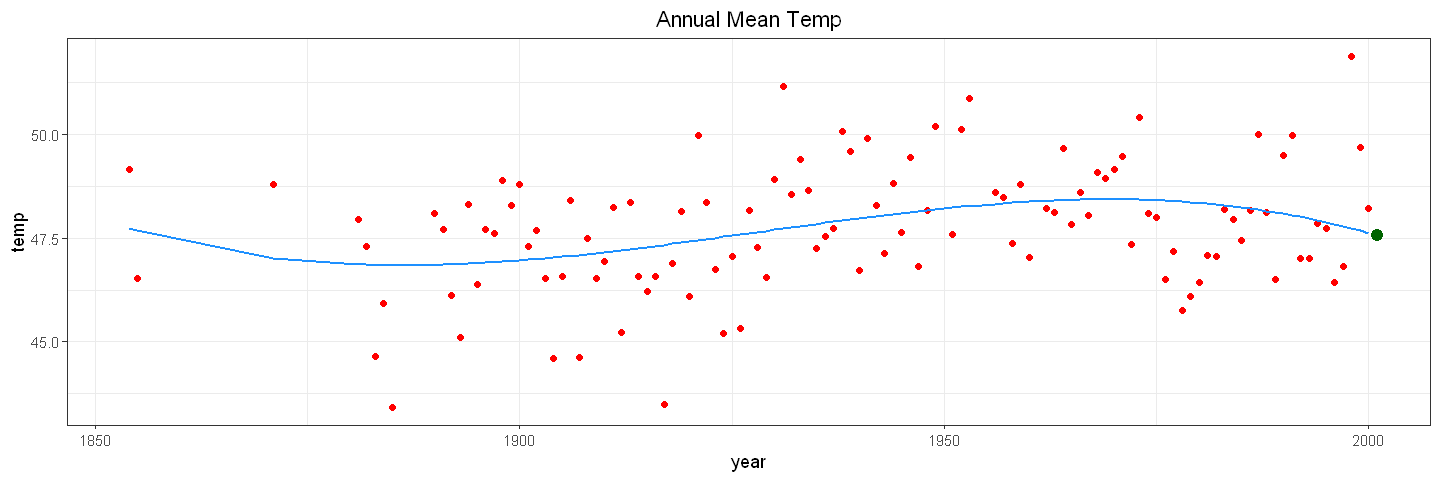

In [396]:
pred = predict(mod_e, aatemp)
ggplot(data = aatemp, aes(x = year, y = temp))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point(color='red')+
    labs(title='Annual Mean Temp', x='year', y = 'temp')+
    geom_line(aes(x = year, y = pred), color = 'dodgerblue', size = 0.75)+
    geom_point(x = 2001, y = predict(mod_e, data.frame(year = 2001)), color = 'darkgreen', size = 3)

<b>(d) Make a cubic spline fit with six basis functions evenly spaced on the data range. Plot the fit in comparison with the previous fit. Does this model fit better than the selected polynomial model?

* number of basis functions = df = 6
* number of knots(m) = 6 - 4 = 2

In [426]:
library(splines)
mod_f = lm(temp ~ bs(year, df = 5, intercept = FALSE), data = aatemp)
summary(mod_f)


Call:
lm(formula = temp ~ bs(year, df = 5, intercept = FALSE), data = aatemp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6461 -0.9101 -0.2006  0.9427  3.3248 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           47.9406     0.9832  48.760   <2e-16 ***
bs(year, df = 5, intercept = FALSE)1  -0.8898     1.6369  -0.544   0.5878    
bs(year, df = 5, intercept = FALSE)2  -2.1812     1.2069  -1.807   0.0735 .  
bs(year, df = 5, intercept = FALSE)3   2.5074     1.3252   1.892   0.0611 .  
bs(year, df = 5, intercept = FALSE)4  -1.8368     1.1956  -1.536   0.1273    
bs(year, df = 5, intercept = FALSE)5   1.2750     1.2123   1.052   0.2953    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.392 on 109 degrees of freedom
Multiple R-squared:  0.2045,	Adjusted R-squared:  0.168 
F-statistic: 5.604 on 5 and 109 DF,  p-value: 0.0001234


In [427]:
RSS = 1.392**2*109
RSS

[1] 211.2054

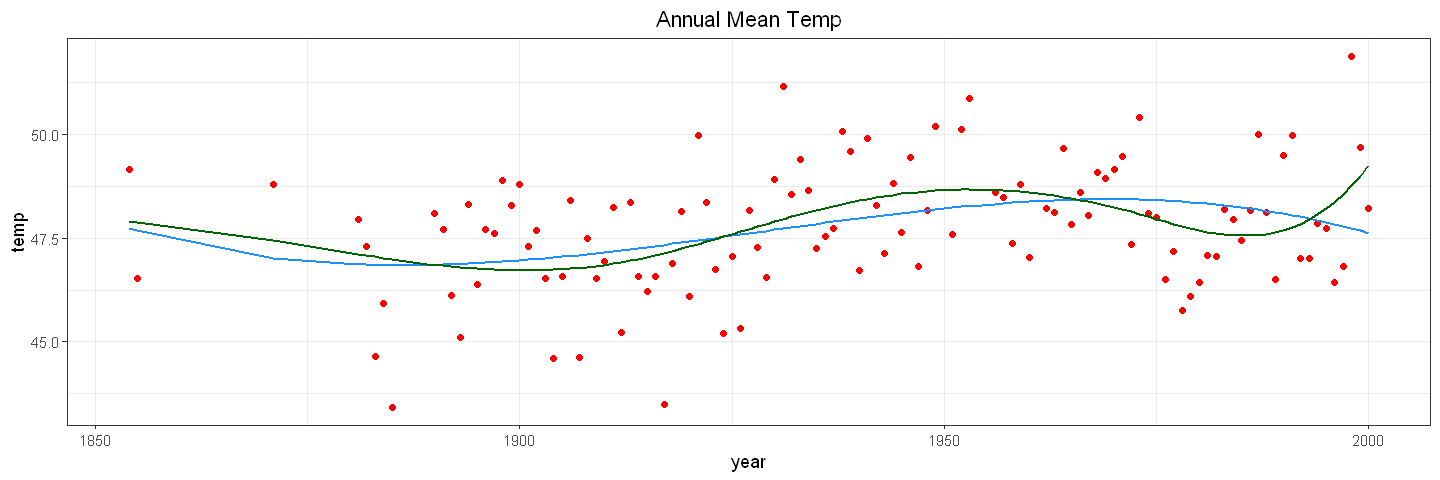

In [401]:
pred = predict(mod_e, aatemp)
pred1 = predict(mod_f, aatemp)
ggplot(data = aatemp, aes(x = year, y = temp))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point(color='red')+
    labs(title='Annual Mean Temp', x='year', y = 'temp')+
    geom_line(aes(x = year, y = pred), color = 'dodgerblue', size = 0.75)+
    geom_line(aes(x = year, y = pred1), color = 'darkgreen', size = 0.75)


* Since RSS for cubic spline model is less and $R^2$ value is higher, cubic spline model fits better.

<b> Problem 2: Consider the infmort data set from the faraway library.

(a) Plot the data and make a brief summary. Which variables are categorical? Which variables are numerical?

(b) Fit a model for the infant mortality in terms of the other variables using the main effects
and up to second order interactions. Comment on your results. 

(c) Check for unsual observations and potential transformations. Re-fit your model if necessary.

(d) Interpret your model by explaining what the regression parameter estimates mean.



In [604]:
library(faraway)
data(infmort)

<b>(a) Plot the data and make a brief summary. Which variables are categorical? Which variables are numerical?

In [605]:
head(infmort)

,region,income,mortality,oil
Australia,Asia,3426,26.7,no oil exports
Austria,Europe,3350,23.7,no oil exports
Belgium,Europe,3346,17.0,no oil exports
Canada,Americas,4751,16.8,no oil exports
Denmark,Europe,5029,13.5,no oil exports
Finland,Europe,3312,10.1,no oil exports


* There are four data points where mortality values missing, hence lets drop them.

In [606]:
infmort = na.omit(infmort)

In [607]:
str(infmort)

'data.frame':	101 obs. of  4 variables:
 $ region   : Factor w/ 4 levels "Africa","Europe",..: 3 2 2 4 2 2 2 2 2 2 ...
 $ income   : num  3426 3350 3346 4751 5029 ...
 $ mortality: num  26.7 23.7 17 16.8 13.5 10.1 12.9 20.4 17.8 25.7 ...
 $ oil      : Factor w/ 2 levels "oil exports",..: 2 2 2 2 2 2 2 2 2 2 ...
 - attr(*, "na.action")= 'omit' Named int  24 83 86 91
  ..- attr(*, "names")= chr  "Iran               " "Haiti              " "Laos               " "Nepal              "


In [608]:
summary(infmort)

      region       income       mortality                  oil    
 Africa  :34   Min.   :  50   Min.   :  9.60   oil exports   : 8  
 Europe  :18   1st Qu.: 130   1st Qu.: 26.20   no oil exports:93  
 Asia    :27   Median : 334   Median : 60.60                      
 Americas:22   Mean   :1022   Mean   : 89.05                      
               3rd Qu.:1191   3rd Qu.:129.40                      
               Max.   :5596   Max.   :650.00                      

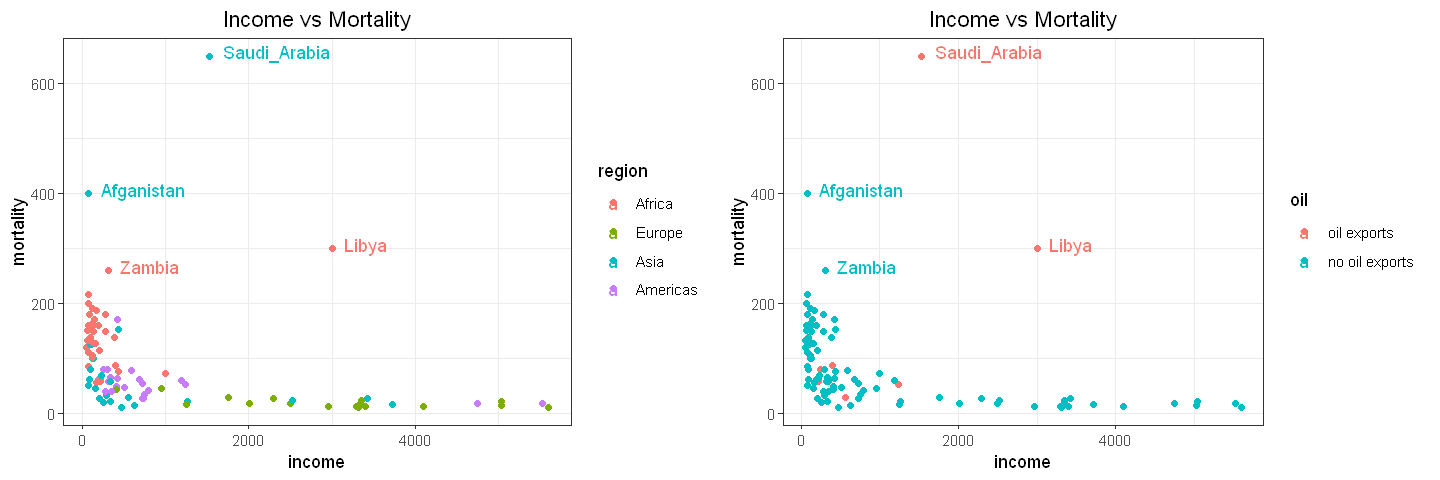

In [609]:
library(gridExtra)
options(repr.plot.width=12, repr.plot.height=4)

plot1 <- ggplot(data = infmort, aes(x = income, y = mortality, color = region))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point()+
    labs(title='Income vs Mortality', x='income', y = 'mortality')+
    geom_text(aes(label=ifelse(mortality>250,as.character(row.names(infmort)),'')),hjust=-0.1,vjust=0.2)

plot2 <- ggplot(data = infmort, aes(x = income, y = mortality, color = oil))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point()+
    labs(title='Income vs Mortality', x='income', y = 'mortality')+
    geom_text(aes(label=ifelse(mortality>250,as.character(row.names(infmort)),'')),hjust=-0.1,vjust=0.2)
grid.arrange(plot1, plot2, nrow = 1)

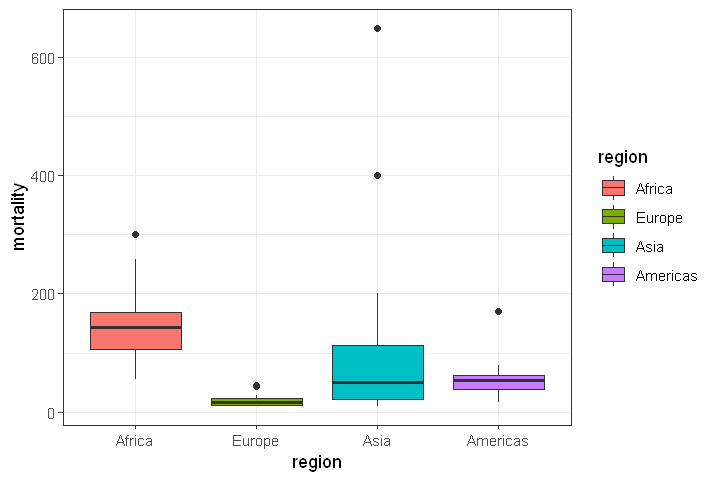

In [610]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(infmort, aes(x = region, y = mortality, fill=region)) + 
  geom_boxplot()

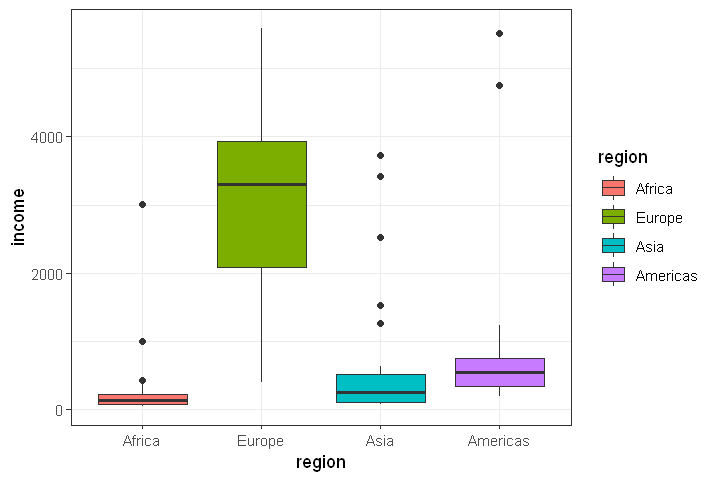

In [611]:
ggplot(infmort, aes(x = region, y = income, fill=region)) + 
  geom_boxplot()

* Variables Region and Oil are categorical variables
* Variables Income and Mortality are numerical variables
* We can see, as the income increases, mortality decreases. There are however two datapoints which come from oil producing countries that looks like outliers.
* Africa is having highest mortality and lowest income.
* Europe is having lowest mortality and highest income.

<b>(b) Fit a model for the infant mortality in terms of the other variables using the main effects and up to second order interactions. Comment on your results.

In [612]:
names(infmort)

[1] "region"    "income"    "mortality" "oil"

In [613]:
mod = lm(mortality ~ income + region + oil + income:region + income:oil + region:oil, data = infmort)

Warning message in predict.lm(mod, infmort):
"prediction from a rank-deficient fit may be misleading"

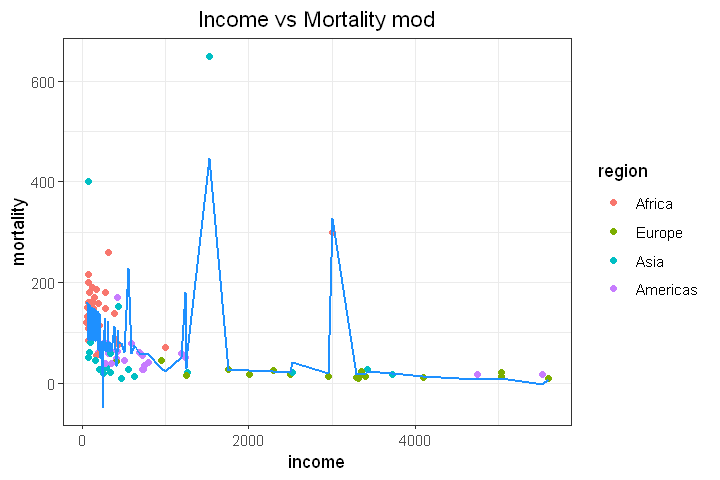

In [614]:
pred = predict(mod, infmort)
plot1 <- ggplot(data = infmort, aes(x = income, y = mortality, color = region))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point()+
    labs(title='Income vs Mortality mod', x='income', y = 'mortality')+
    geom_line(aes(x = income, y = pred), color = 'dodgerblue', size = 0.75)
plot1

In [615]:
summary(mod)


Call:
lm(formula = mortality ~ income + region + oil + income:region + 
    income:oil + region:oil, data = infmort)

Residuals:
     Min       1Q   Median       3Q      Max 
-200.606  -23.858   -2.578   15.676  314.797 

Coefficients: (1 not defined because of singularities)
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        27.88469   48.70131   0.573 0.568383    
income                              0.09935    0.02687   3.697 0.000376 ***
regionEurope                     -133.35340   37.99857  -3.509 0.000707 ***
regionAsia                         74.83990   64.29758   1.164 0.247550    
regionAmericas                   -134.64863   69.44359  -1.939 0.055674 .  
oilno oil exports                 140.12320   48.65760   2.880 0.004984 ** 
income:regionEurope                 0.13887    0.04451   3.120 0.002441 ** 
income:regionAsia                   0.12561    0.04368   2.876 0.005041 ** 
income:regionAmericas               0.

In [618]:
round(anova(mod),4)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
income,1,90086.162,90086.162,22.8401,0.0000
region,3,121982.055,40660.685,10.3090,0.0000
oil,1,43936.012,43936.012,11.1394,0.0012
income:region,3,5338.328,1779.443,0.4512,0.7171
income:oil,1,165627.542,165627.542,41.9926,0.0000
region:oil,2,46490.523,23245.261,5.8935,0.0039
Residuals,89,351034.371,3944.206,NA,NA


* We can see income:region is not significant at 5% significance level. Lets drop it.

In [621]:
mod = lm(mortality ~ income + region + oil + income:oil + region:oil, data = infmort)
summary(mod)
round(anova(mod),4)


Call:
lm(formula = mortality ~ income + region + oil + income:oil + 
    region:oil, data = infmort)

Residuals:
    Min      1Q  Median      3Q     Max 
-217.07  -27.38   -4.37   18.65  318.04 

Coefficients: (1 not defined because of singularities)
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        -9.18489   48.75605  -0.188  0.85099    
income                              0.12999    0.02568   5.061 2.12e-06 ***
regionEurope                      -86.34203   26.74772  -3.228  0.00173 ** 
regionAsia                        181.56071   54.52280   3.330  0.00125 ** 
regionAmericas                    -22.55581   60.59049  -0.372  0.71055    
oilno oil exports                 153.22243   50.15122   3.055  0.00294 ** 
income:oilno oil exports           -0.14263    0.02649  -5.385 5.53e-07 ***
regionEurope:oilno oil exports           NA         NA      NA       NA    
regionAsia:oilno oil exports     -242.69014   57.40058  -4.228 5

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
income,1,90086.16,90086.162,21.2753,0.0000
region,3,121982.05,40660.685,9.6027,0.0000
oil,1,43936.01,43936.012,10.3762,0.0018
income:oil,1,96435.06,96435.058,22.7747,0.0000
region:oil,2,82499.89,41249.947,9.7419,0.0001
Residuals,92,389555.81,4234.302,NA,NA


* We can see, not much of the variation in mortality is explained by the model. It is having $R^2$ value of 0.5275 with large residual standard error of 65.07. 

<b>(c) Check for unsual observations and potential transformations. Re-fit your model if necessary.

We will apply log transformation to income as well as mortality

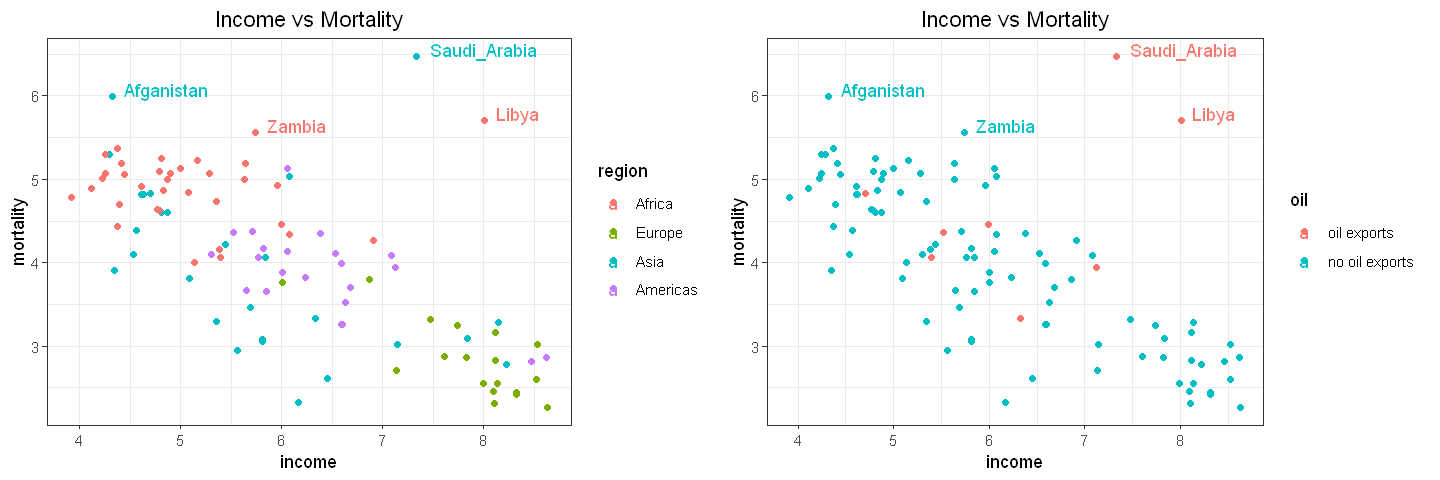

In [295]:
options(repr.plot.width=12, repr.plot.height=4)

plot1 <- ggplot(data = infmort, aes(x = log(income), y = log(mortality), color = region))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point()+
    labs(title='Income vs Mortality', x='income', y = 'mortality')+
    geom_text(aes(label=ifelse(mortality>250,as.character(row.names(infmort)),'')),hjust=-0.1,vjust=0)

plot2 <- ggplot(data = infmort, aes(x = log(income), y = log(mortality), color = oil))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point()+
    labs(title='Income vs Mortality', x='income', y = 'mortality')+
    geom_text(aes(label=ifelse(mortality>250,as.character(row.names(infmort)),'')),hjust=-0.1,vjust=0)
grid.arrange(plot1, plot2, nrow = 1)

In [623]:
mod_b = lm(log(mortality) ~ log(income) + region + oil + log(income):region + log(income):oil + region:oil, data = infmort)
summary(mod_b)
round(anova(mod_b),4)


Call:
lm(formula = log(mortality) ~ log(income) + region + oil + log(income):region + 
    log(income):oil + region:oil, data = infmort)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.60045 -0.28092 -0.00656  0.29879  1.45482 

Coefficients: (1 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        0.6752     1.3167   0.513 0.609348    
log(income)                        0.6288     0.1982   3.173 0.002071 ** 
regionEurope                       1.3934     1.6641   0.837 0.404648    
regionAsia                         2.5569     1.0756   2.377 0.019586 *  
regionAmericas                     1.5482     1.2925   1.198 0.234146    
oilno oil exports                  4.9580     1.2508   3.964 0.000149 ***
log(income):regionEurope          -0.3825     0.2352  -1.627 0.107364    
log(income):regionAsia            -0.3596     0.1563  -2.301 0.023743 *  
log(income):regionAmericas        -0

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
log(income),1,47.0835,47.0835,170.2772,0.0000
region,3,10.7053,3.5684,12.9052,0.0000
oil,1,2.8243,2.8243,10.2142,0.0019
log(income):region,3,1.7052,0.5684,2.0556,0.1118
log(income):oil,1,4.0678,4.0678,14.7110,0.0002
region:oil,2,2.7732,1.3866,5.0147,0.0086
Residuals,89,24.6094,0.2765,NA,NA


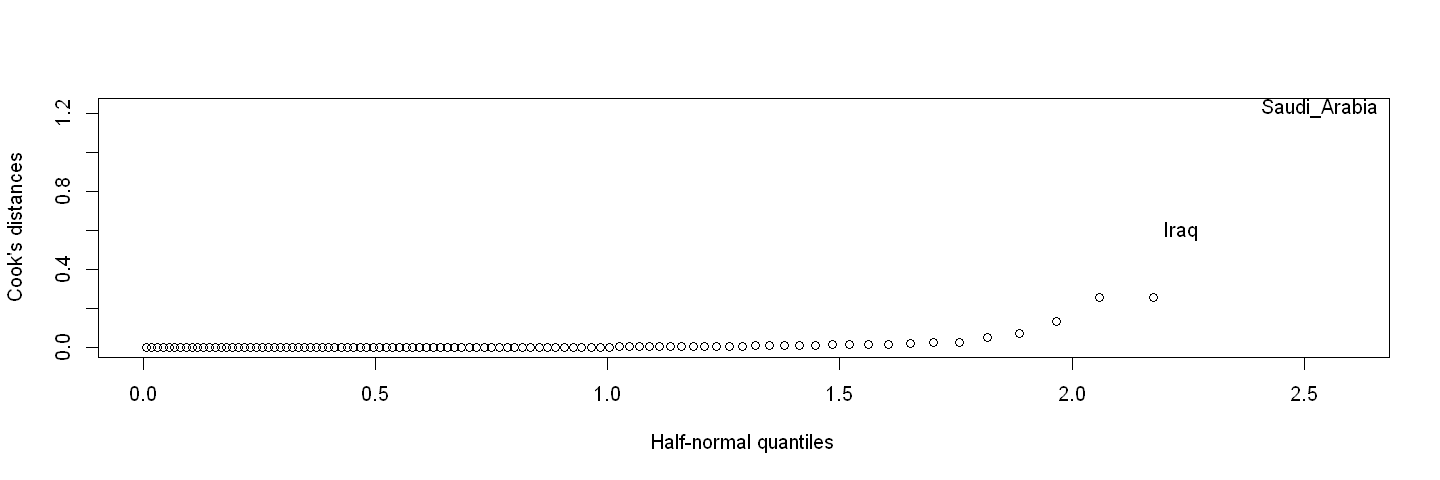

In [624]:
options(repr.plot.width=12, repr.plot.height=4)
cook = cooks.distance(mod_b)
halfnorm(cook, labs=row.names(infmort), ylab="Cook's distances")

* Although there not significant outliers, values of cook's distance for Iraq and Saudi_Arabia are significantly higher than rest of the other datapoints. So, lets remove them and see what effect it will have on our model performance.

In [242]:
new_infmort = infmort
# new_infmort = new_infmort[row.names(new_infmort) != 'Libya              ',]
new_infmort = new_infmort[row.names(new_infmort) != 'Iraq               ',]
new_infmort = new_infmort[row.names(new_infmort) != 'Saudi_Arabia       ',]

In [243]:
row.names(new_infmort)

[1] "Australia          " "Austria            " "Belgium            "
 [4] "Canada             " "Denmark            " "Finland            "
 [7] "France             " "West_Germany       " "Ireland            "
[10] "Italy              " "Japan              " "Netherlands        "
[13] "New_Zealand        " "Norway             " "Portugal           "
[16] "South_Africa       " "Sweden             " "Switzerland        "
[19] "Britain            " "United_States      " "Algeria            "
[22] "Ecuador            " "Indonesia          " "Libya              "
[25] "Nigeria            " "Venezuela          " "Argentina          "
[28] "Brazil             " "Chile              " "Colombia           "
[31] "Costa_Rica         " "Dominican_Republic " "Greece             "
[34] "Guatemala          " "Israel             " "Jamaica            "
[37] "Lebanon            " "Malaysia           " "Mexico             "
[40] "Nicaragua          " "Panama             " "Peru               "
[43] "Singapore          " "Spain              " "Taiwan             "
[46] "Trinidad_and_Tobago" "Tunisia            " "Uruguay            "
[49] "Yugoslavia         " "Zambia             " "Bolivia            "
[52] "Cameroon           " "Congo              " "Egypt              "
[55] "El_Salvador        " "Ghana              " "Honduras           "
[58] "Ivory_Coast        " "Jordan             " "South_Korea        "
[61] "Liberia            " "Moroco             " "Papua_New_Guinea   "
[64] "Paraguay           " "Philippines        " "Syria              "
[67] "Thailand           " "Turkey             " "South_Vietnam      "
[70] "Afganistan         " "Bangladesh         " "Burma              "
[73] "Burundi            " "Cambodia           " "Central_African_Rep"
[76] "Chad               " "Dahomey            " "Ethiopia           "
[79] "Guinea             " "India              " "Kenya              "
[82] "Madagascar         " "Malawi             " "Mali               "
[85] "Mauritania         " "Niger              " "Pakistan           "
[88] "Rwanda             " "Sierra_Leone       " "Somalia            "
[91] "Sri_Lanka          " "Sudan              " "Tanzania           "
[94] "Togo               " "Uganda             " "Upper_Volta        "
[97] "Southern_Yemen     " "Yemen              " "Zaire              "

In [625]:
mod_c = lm(log(mortality) ~ log(income) + region + oil + log(income)*region + log(income)*oil + region*oil, data = new_infmort)
# mod_c = lm(log(mortality) ~ log(income)*region*oil, data = new_infmort)
summary(mod_c)
round(anova(mod_c),4)


Call:
lm(formula = log(mortality) ~ log(income) + region + oil + log(income) * 
    region + log(income) * oil + region * oil, data = new_infmort)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.26138 -0.26401 -0.01274  0.29714  1.42471 

Coefficients: (1 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)                        1.5832     1.4429   1.097  0.27557   
log(income)                        0.4884     0.2190   2.230  0.02831 * 
regionEurope                       1.5898     1.5336   1.037  0.30278   
regionAsia                         2.9323     1.0202   2.874  0.00509 **
regionAmericas                     1.6810     1.1893   1.413  0.16108   
oilno oil exports                  3.8537     1.4970   2.574  0.01174 * 
log(income):regionEurope          -0.4222     0.2181  -1.936  0.05617 . 
log(income):regionAsia            -0.4219     0.1531  -2.755  0.00714 **
log(income):regionAmericas        -

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
log(income),1,50.6662,50.6662,218.4763,0.0000
region,3,10.4303,3.4768,14.9920,0.0000
oil,1,0.8610,0.8610,3.7127,0.0573
log(income):region,3,3.4286,1.1429,4.9281,0.0033
log(income):oil,1,0.7023,0.7023,3.0285,0.0854
region:oil,2,1.1002,0.5501,2.3722,0.0993
Residuals,87,20.1759,0.2319,NA,NA


* After removing these two datapoints, residual standard error has reduced from 0.7376 to 0.7691 and $R^2$ value increased from 0.5258 to 0.7691.

Warning message in predict.lm(mod_c, new_infmort):
"prediction from a rank-deficient fit may be misleading"

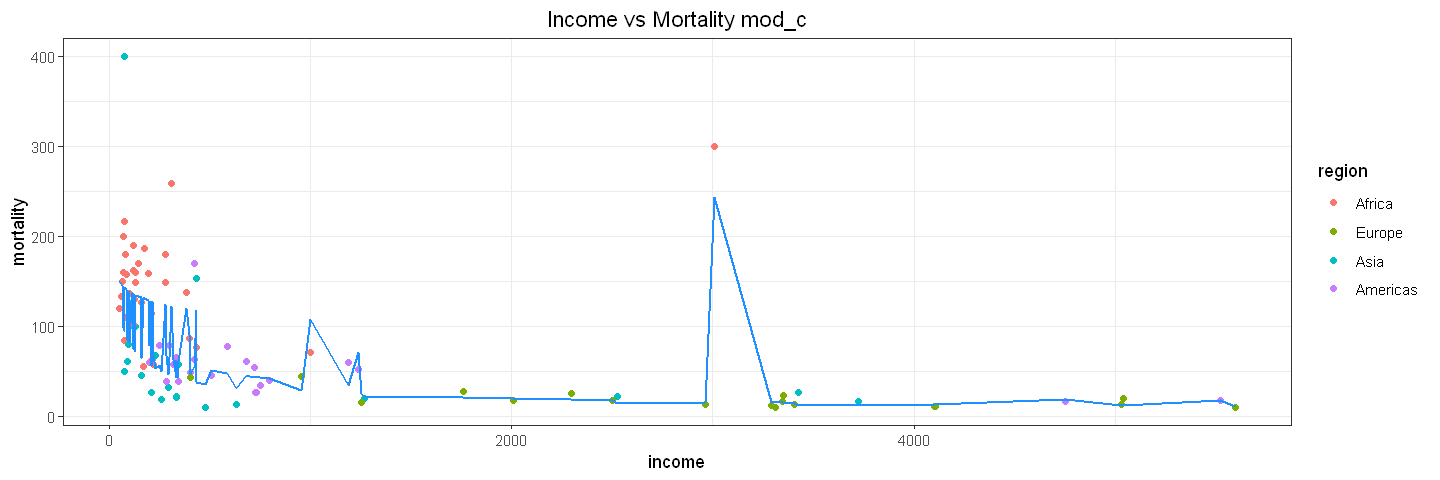

In [298]:
pred = exp(predict(mod_c, new_infmort))
plot1 <- ggplot(data = new_infmort, aes(x = income, y = mortality, color = region))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point()+
    labs(title='Income vs Mortality mod_c', x='income', y = 'mortality')+
    geom_line(aes(x = income, y = pred), color = 'dodgerblue', size = 0.75)
plot1

<b>(d) Interpret your model by explaining what the regression parameter estimates mean.

* Interaction is created by product of any two variables.

$\hat{y}= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1*x_2$

* $\beta_0$ is intecept
* $\beta_1$ is slope when $x_2$ is zero
* $\beta_2$ is the slope when $x_1$ is zero
* $\beta_3$ is the interaction term; change in slope of $x_1$ when $x_2$ changes by unity and vice versa
* In the similar way, we can interpret the $\beta$ values estimated by our model for different interactions.
* The interactions region-Europe and oil-no oil exports, region-America and oil-no oil exports, and log(income) and region-Europe are not significant at 5% $\alpha$ level.
* The residual standard error is 0.4816. 76.91% of the variation in mortality is explained by the model.

<b> Problem 3: Generate 100 observations from the model $y = \sin^3(2πx^3) + ε$, with $ε ∼N(0,(0.1)^2)$. (The model is described in section 9.5 of the textbook).
    
(a) Fit regression splines with 12 evenly-spaced knots using $y ∼ bs(x, knots = . . .)$. You need to load the splines package. Display the fit on top of the data.
    
(b) Compute the AIC for this model.
    
(c) Compute the Adjusted $R^2$
    
(d) Compute the AIC for all models with a number of knots between 3 and 20 inclusive.
Plot the AIC as a function of the number of degrees of freedom. Which model is the
best?
    
(e) Plot the fit for your selected model on top of the data.

Generate 100 observations

In [111]:
set.seed(42)
e = rnorm(n = 100, mean = 0, sd = 0.1)
x = seq(0, 0.99, by = 0.01)
y = sin(2*pi*x^3)^3 + e
data = data.frame(x, y)

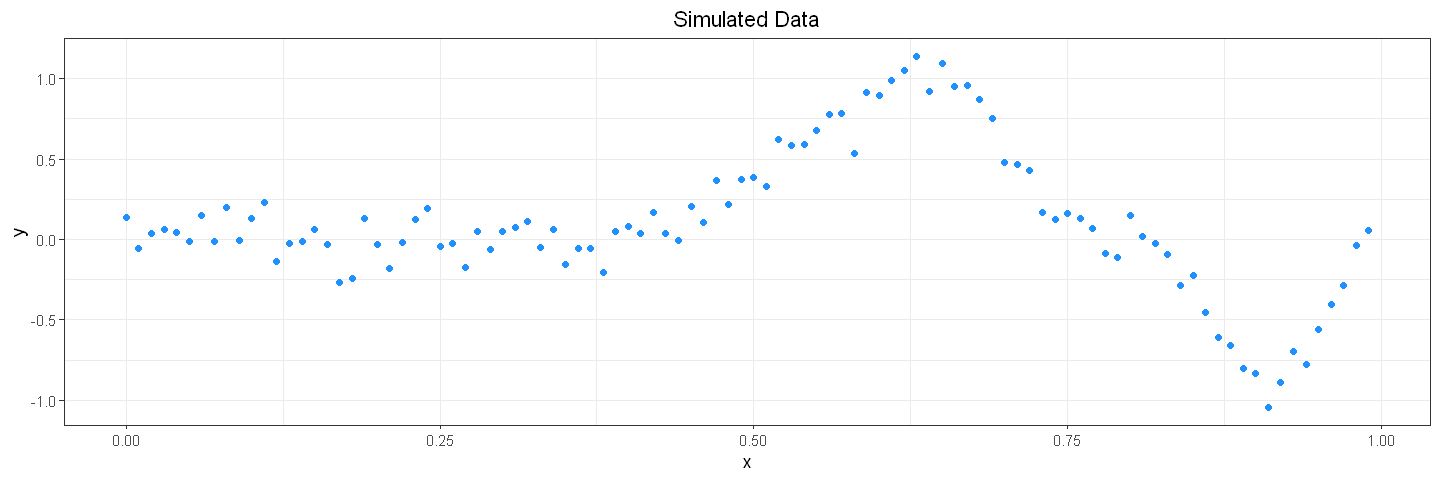

In [112]:
options(repr.plot.width=12, repr.plot.height=4)

plot1 <- ggplot(data = data, aes(x = x, y = y))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point(color = 'dodgerblue')+
    labs(title='Simulated Data', x='x', y = 'y')
plot1

<b>(a) Fit regression splines with 12 evenly-spaced knots using  𝑦∼𝑏𝑠(𝑥,𝑘𝑛𝑜𝑡𝑠=...) . You need to load the splines package. Display the fit on top of the data.

In [113]:
library(splines)

In [114]:
m=12;
myknots= 2*(1:m)/(m+1)
myknots

[1] 0.1538462 0.3076923 0.4615385 0.6153846 0.7692308 0.9230769 1.0769231
 [8] 1.2307692 1.3846154 1.5384615 1.6923077 1.8461538

In [115]:
F = bs(x,knots=myknots, intercept=TRUE) #Using the Intercept option
dim(F)

[1] 100  16

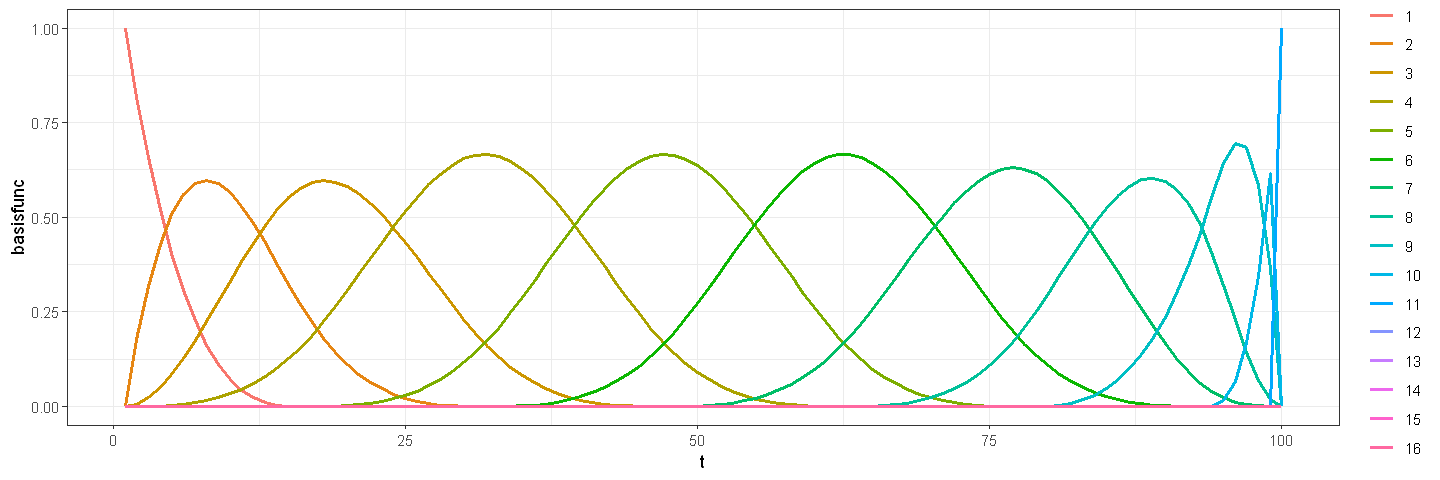

In [116]:
mydf = m+4
n = length(x)
tmpdata = data.frame(t = rep(1:n, mydf),
                     basisfunc=as.vector(F), 
                     type=as.factor(rep(1:mydf, each=n)))
ggplot(tmpdata, aes(x=t, y=basisfunc, color=type)) + 
  geom_path(size = 1)
#   geom_point(data = data, aes(x = x, y = y),color = 'dodgerblue')

In [117]:
mod_using_knots = lm(y ~ bs(x, knots = myknots, intercept = TRUE))
summary(mod_using_knots)


Call:
lm(formula = y ~ bs(x, knots = myknots, intercept = TRUE))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33482 -0.06863 -0.00407  0.08639  0.26544 

Coefficients: (6 not defined because of singularities)
                                           Estimate Std. Error t value Pr(>|t|)
(Intercept)                                 0.05893    0.13222   0.446    0.657
bs(x, knots = myknots, intercept = TRUE)1  -0.04326    0.16158  -0.268    0.790
bs(x, knots = myknots, intercept = TRUE)2   0.10771    0.17240   0.625    0.534
bs(x, knots = myknots, intercept = TRUE)3  -0.20294    0.16962  -1.196    0.235
bs(x, knots = myknots, intercept = TRUE)4   0.01653    0.15682   0.105    0.916
bs(x, knots = myknots, intercept = TRUE)5  -0.19558    0.15424  -1.268    0.208
bs(x, knots = myknots, intercept = TRUE)6   1.39757    0.15554   8.985 4.03e-14
bs(x, knots = myknots, intercept = TRUE)7  -0.01946    0.16373  -0.119    0.906
bs(x, knots = myknots, intercept = TRUE)8  -0.80570   

In [118]:
mod_a = lm(y ~ bs(x, df = 15, intercept = FALSE), data = data)
summary(mod_a)


Call:
lm(formula = y ~ bs(x, df = 15, intercept = FALSE), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30926 -0.06214  0.01633  0.05692  0.20160 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          0.09976    0.08783   1.136  0.25923    
bs(x, df = 15, intercept = FALSE)1  -0.21117    0.17296  -1.221  0.22553    
bs(x, df = 15, intercept = FALSE)2   0.19561    0.12645   1.547  0.12563    
bs(x, df = 15, intercept = FALSE)3  -0.28894    0.13450  -2.148  0.03457 *  
bs(x, df = 15, intercept = FALSE)4  -0.06883    0.11729  -0.587  0.55893    
bs(x, df = 15, intercept = FALSE)5  -0.06679    0.12295  -0.543  0.58840    
bs(x, df = 15, intercept = FALSE)6  -0.21186    0.11894  -1.781  0.07848 .  
bs(x, df = 15, intercept = FALSE)7   0.09149    0.12081   0.757  0.45100    
bs(x, df = 15, intercept = FALSE)8   0.40649    0.11976   3.394  0.00105 ** 
bs(x, df = 15, intercept = FALSE)9   0.

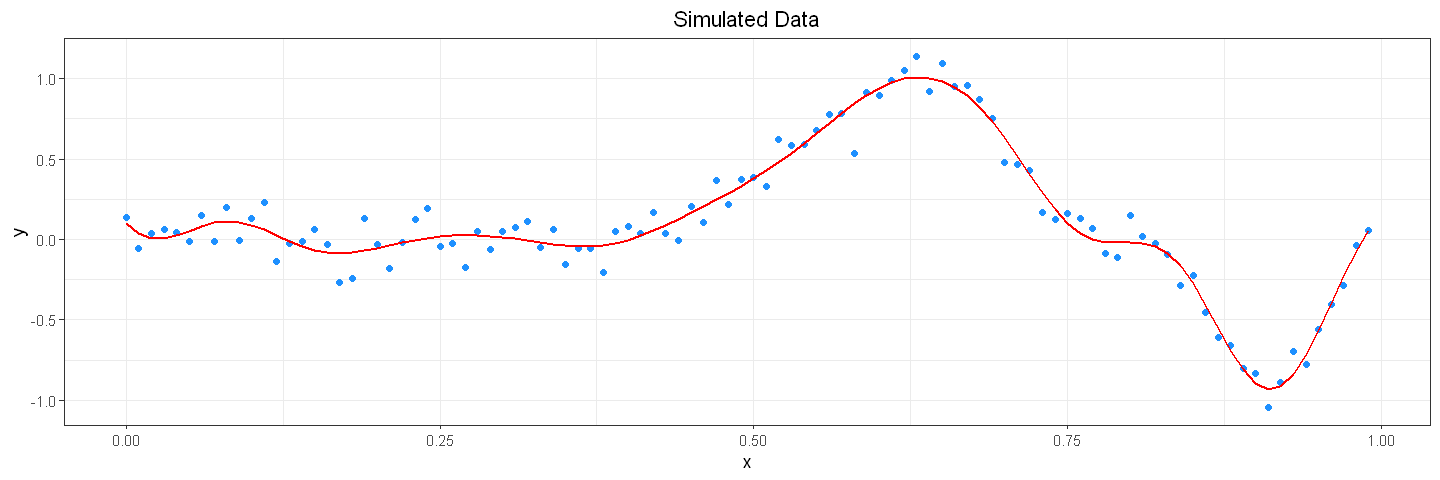

In [119]:
pred = predict(mod_a, data)
plot1 <- ggplot(data = data, aes(x = x, y = y))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point(color = 'dodgerblue')+
    labs(title='Simulated Data', x='x', y = 'y')+
    geom_line(aes(x = x, y = pred), color = 'red', size = 0.75)
plot1

<b>(b) Compute the AIC for this model.

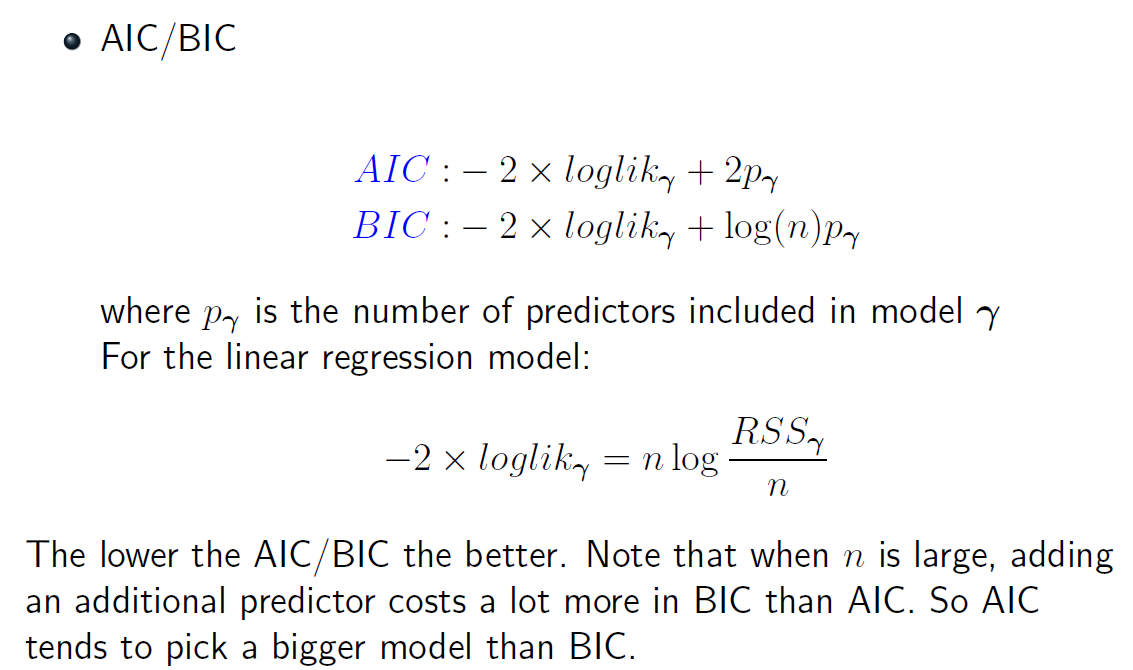

$p_\gamma$ is number of parameters

In [120]:
AIC_mod_a = n*log(sum(mod_a$residuals**2)/n) + 2*16
AIC_mod_a

[1] -443.1582

<b>(c) Compute the Adjusted  𝑅2

<img src = "https://wikimedia.org/api/rest_v1/media/math/render/svg/16a082d105dfbb4339e40cf7898950ce748743e8">

image source: https://en.wikipedia.org/wiki/Coefficient_of_determination

$\bar{R}^2$ is adjusted $R^2$

In [122]:
Adj_R_squared_for_model_with_df = 1 - ((1 - 0.957)*(100-1))/(100-15-1)
Adj_R_squared_for_model_with_df

[1] 0.9493214

In [129]:
Adj_R_squared_for_model_with_knots = 1 - ((1 - 0.9226)*(100-1))/(100-10-1)
Adj_R_squared_for_model_with_knots

[1] 0.9139034

<b>(d) Compute the AIC for all models with a number of knots between 3 and 20 inclusive. Plot the AIC as a function of the number of degrees of freedom. Which model is the best?

* We need to use knots between 3 and 20. Hence degrees of freedom for the models without intercept = false, will be between 6 to 23.

In [130]:
DoFs = 6:23
# DoFs = 7:24

In [131]:
create_models = function(df){
    mod = lm(y ~ bs(x, df = df, intercept = FALSE), data = data)
    rss = sum(mod$residuals**2)
}

In [132]:
models_RSS = sapply(DoFs, create_models)
models_RSS

[1] 2.4225234 1.9714066 1.8771097 1.6216638 1.3026094 1.4213909 1.5010463
 [8] 1.0951205 0.8224321 0.8638016 0.8672367 0.8348153 0.8390777 0.8097228
[15] 0.7969341 0.7792510 0.8060829 0.7699186

In [133]:
Calc_AIC_first_term = function(models_RSS){
    n*log(sum(models_RSS)/n)
}

In [134]:
AICs = sapply(models_RSS, Calc_AIC_first_term) + 2*(DoFs+1)
AICs

[1] -358.0360 -376.6423 -379.5437 -392.1718 -412.0801 -401.3534 -393.9008
 [8] -423.4306 -450.0660 -443.1582 -440.7613 -442.5715 -440.0622 -441.6233
[15] -441.2153 -441.4592 -436.0739 -438.6641

In [135]:
which.min(AICs)

[1] 9

In [136]:
DoFs[9]

[1] 14

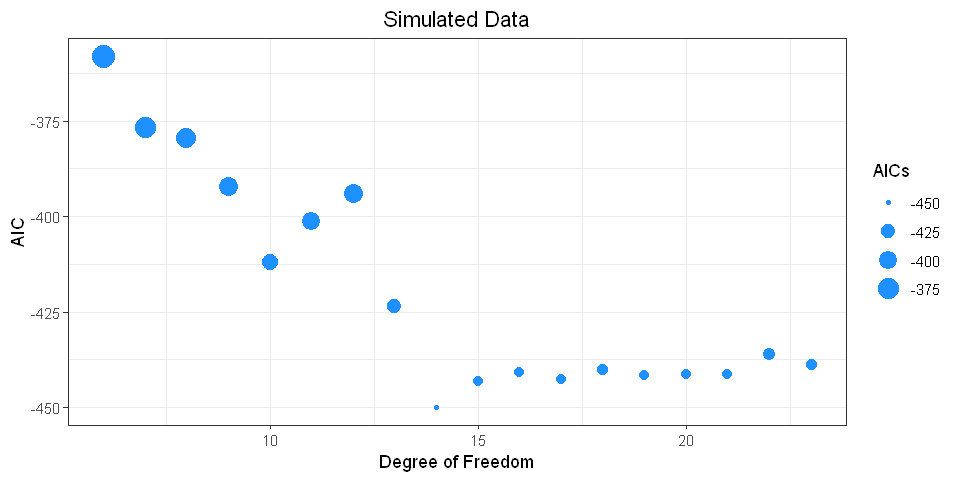

In [137]:
options(repr.plot.width=8, repr.plot.height=4)

plot1 <- ggplot(data = data.frame(DoFs, AICs), aes(x = DoFs, y = AICs, size = AICs))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point(color = 'dodgerblue')+
    labs(title='Simulated Data', x='Degree of Freedom', y = 'AIC')
plot1

* Model with 14 Degrees of freedom (11 knots) has lowest AIC.

<b>(e) Plot the fit for your selected model on top of the data.

In [138]:
final_model = lm(y ~ bs(x, df = 14, intercept = FALSE), data = data)
summary(final_model)


Call:
lm(formula = y ~ bs(x, df = 14, intercept = FALSE), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.26586 -0.05829  0.01427  0.05113  0.21274 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          0.090284   0.083543   1.081 0.282893    
bs(x, df = 14, intercept = FALSE)1  -0.174700   0.163641  -1.068 0.288732    
bs(x, df = 14, intercept = FALSE)2   0.188217   0.118269   1.591 0.115226    
bs(x, df = 14, intercept = FALSE)3  -0.311307   0.126884  -2.453 0.016190 *  
bs(x, df = 14, intercept = FALSE)4   0.006656   0.110363   0.060 0.952049    
bs(x, df = 14, intercept = FALSE)5  -0.130496   0.115917  -1.126 0.263432    
bs(x, df = 14, intercept = FALSE)6  -0.151316   0.112041  -1.351 0.180425    
bs(x, df = 14, intercept = FALSE)7   0.308877   0.113888   2.712 0.008090 ** 
bs(x, df = 14, intercept = FALSE)8   0.643346   0.112934   5.697 1.71e-07 ***
bs(x, df = 14, intercept = FA

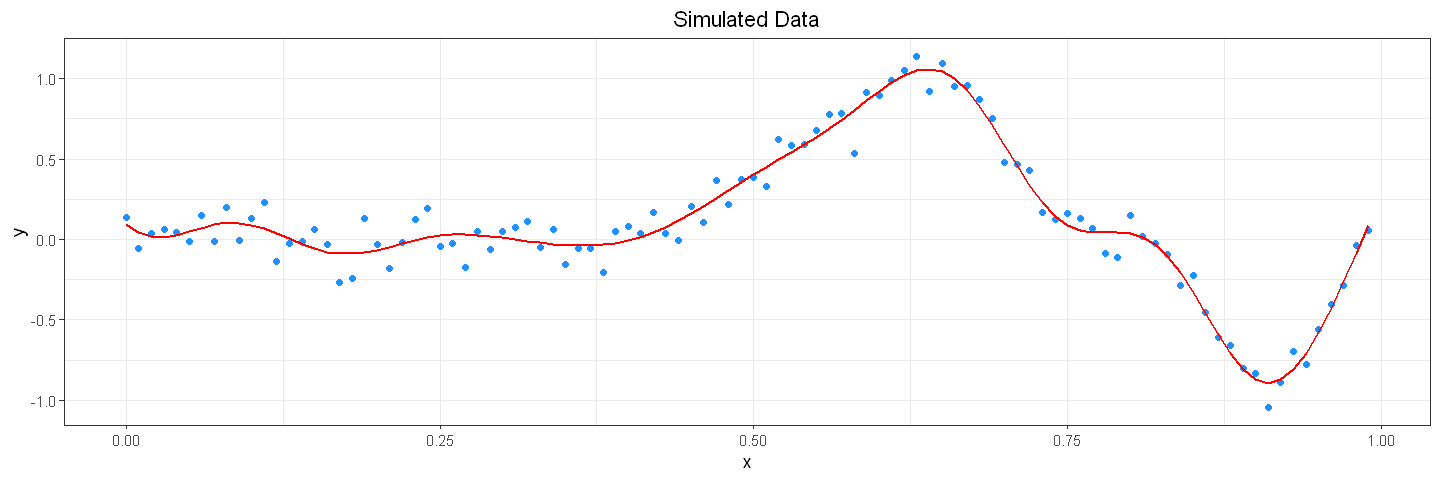

In [139]:
options(repr.plot.width=12, repr.plot.height=4)

pred = predict(final_model, data)
plot1 <- ggplot(data = data, aes(x = x, y = y))+
    geom_point()+
    theme_update(plot.title = element_text(hjust = 0.5))+
    theme_set(theme_bw())+
    geom_point(color = 'dodgerblue')+
    labs(title='Simulated Data', x='x', y = 'y')+
    geom_line(aes(x = x, y = pred), color = 'red', size = 0.75)
plot1

In [140]:
AIC_final_model = n*log(sum(final_model$residuals**2)/n) + 2*15
AIC_final_model

[1] -450.066